In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import *
from scipy.interpolate import Rbf
from numpy import random

### Consider the Bilinear DC Motor given by the equations:

$\dot{x_1} = -(R_a/L_a)x_1-(k_m/L_a)x_2u+u_a/L_a$

$\dot{x_2} = -(B/J)x_2+(k_m/J)x_1u-\tau_1/J$

$y = x_2$

In [2]:
# define the dynamics
# x1 - current in [-1,1]
# x2 - angular velocity in [-1,1]
# u  - control input in [-1,1]

def dyn_motor_scaled(t,x,u):
    
    dx1dt = -39.3153*x[0]-32.2293*x[1]*u+19.10828025
    dx2dt = -1.6599*x[1]+22.9478*x[0]*u-3.333333333
    
    dXdt = np.asarray([dx1dt,dx2dt])
    
    return dXdt

### Define Some Helper Functions

In [3]:
# RK4

k1 = lambda t,x,u: dyn_motor_scaled(t,x,u)
k2 = lambda t,x,u: dyn_motor_scaled(t,x+k1(t,x,u)*dt/2,u)
k3 = lambda t,x,u: dyn_motor_scaled(t,x+k2(t,x,u)*dt/2,u)
k4 = lambda t,x,u: dyn_motor_scaled(t,x+k1(t,x,u)*dt,u)

rk4_step = lambda t,x,u: x+(dt/6)*(k1(t,x,u)+2*k2(t,x,u)+2*k3(t,x,u)+k4(t,x,u))

In [4]:
# define the Radial Basis Function that will aid in lifting the states
def rbf(X,C,rbf_type):
    
    Cbig = C ; Y = np.zeros([C.shape[1],X.shape[1]])
    
    for i in range(Cbig.shape[1]):
        
        C = np.asarray([Cbig[:,i]]).T
        C = np.tile(C,X.shape[1])
        r_squared = np.sum((X-C)**2,axis = 0)
        
        r_squared = np.reshape(r_squared,(1,len(r_squared)))
        y = r_squared*np.log(np.sqrt(r_squared))
        
        Y[i,:] = y
    
    return Y

### Collect Data

In [28]:
# define some relevant parameters

dt = 0.01 # sampling time
nstates = 2 # number of states
nctrl = 1 # number of control inputs

Tmax = 10
Nsim = int(Tmax/dt)
n = np.arange(0,Nsim)*dt

Ntraj = 200

# first trajectory
# random forcing
u1 = 2*np.random.uniform(0,1,[Nsim,1]) - 1
# random initial condition
x0_1 = np.random.uniform(0,1,[nstates,1])*2 - 1
train_traj1 = np.empty([nstates,Nsim])

x_current = x0_1
for i in range(Nsim):
    train_traj1[:,i] = np.squeeze(x_current)
    x_current = rk4_step(0,x_current,u1[i])

train_traj = train_traj1
u = u1

# remaining Ntraj-1 trajectories
for i in range(1,Ntraj):
    # random forcing
    u_temp = 2*np.random.uniform(0,1,[Nsim,1]) - 1
    # random initial condition
    x0_temp = np.random.uniform(0,1,[nstates,1])*2 - 1
    train_traj_temp = np.empty([nstates,Nsim])
    
    x_current = x0_temp
    for j in range(Nsim):
        train_traj_temp[:,j] = np.squeeze(x_current)
        x_current = rk4_step(0,x_current,u_temp[j])
    
    train_traj = np.hstack([train_traj,train_traj_temp])
    u = np.concatenate([u,u_temp])
        

Cy = np.asarray([[1, 1]]) # Output matrix: y = Cy*x
nD = 1 # Number of delays
ny = Cy.shape[1] # Number of outputs

# Delay-embedded "state" 
# zeta_k = [y_{k} ; u_{k-1} ; y_{k-1} ... u_{k-nd} ; y_{k-nd} ]
n_zeta = (nD+1)*ny + nD*nctrl # dimension of the delay-embedded "state"

# Build Hankel Matrix
H = np.empty([n_zeta,Ntraj*Nsim-nD])
H[:ny,:] = np.dot(Cy,train_traj[:,:-nD]) 
H[ny:int(2*ny),:] = np.dot(Cy,train_traj[:,1:]) 
H[n_zeta-nctrl,:] = np.squeeze(u[:-1])

# Build delay embedded X and Y Matrices
X = H[:,:-1]; Y = H[:,1:]
# Build U Matrix 
U = u[:X.shape[1],:].T

In [30]:
H.shape

(5, 199999)

In [31]:
Nrbf = 100 # number of RBF centers
cent = np.random.uniform(0,1,[n_zeta,Nrbf])*2-1 # generate random RBF centers
rbf_type = 'thin_plate' # specify the type of RBF

# obtain the lifted states
liftFun = lambda xx,cent: np.vstack([xx,rbf(xx,cent,rbf_type)])
# update the total dimension of the lifted state vector
Nlift = Nrbf+n_zeta

### Lift

In [32]:
Xlift = liftFun(X,cent)
Ylift = liftFun(Y,cent)

print(Xlift.shape,Ylift.shape,U.shape) # print out shapes as a sanity check

(105, 199998) (105, 199998) (1, 199998)


### Build Predictor

In [33]:
W = np.vstack([Ylift,X])
V = np.vstack([Xlift,U])

VVt = np.dot(V,V.T)
WVt = np.dot(W,V.T)
M = np.dot(WVt,np.linalg.pinv(VVt)) # Matrix [A B; C 0]
Alift = M[0:Nlift,0:Nlift]
Blift = M[0:Nlift,Nlift:]
Clift = M[Nlift:,0:Nlift]

print(Alift.shape, Blift.shape, Clift.shape) # print out dimensions as a sanity check

(105, 105) (105, 1) (5, 105)


In [34]:
residual = np.linalg.norm(Ylift - np.dot(Alift,Xlift) - np.dot(Blift,U),'fro') / np.linalg.norm(Ylift,'fro')
print(residual)

0.26763652732265636


### Check Predictor Performance

In [35]:
def myprbs(N,dutyCycle):
    
    N = np.asarray([N,1])
        
    y = np.random.uniform(0,1,N)
    y = np.double(y > (1 - dutyCycle))
    
    return y

In [36]:
Nsim_test = 2000 #U.shape[1]
# random forcing
u_test = (2*myprbs(Nsim_test,0.5) - 1)
# random forcing sample
u_test_sample = u_test[0:nctrl,:]
# random initial condition
x0_test = np.random.uniform(0,1,[nstates,1])*2 - 1
delay_init = np.vstack([x0_test,u_test_sample])

# Inital conditions
x_true = x0_test
xlift = liftFun(delay_init,cent)
print(xlift.shape)

# Simulation
for i in range(Nsim_test-1):
    
    # True dynamics
    x_true = np.hstack([x_true, rk4_step(0,np.asarray([x_true[:,-1]]).T,u_test[i,:])]) 
    
    # Koopman predictor
    term1 = np.dot(Alift,np.asarray([xlift[:,-1]]).T)
    term2 = np.dot(Blift,np.asarray([u_test[i,:]]))
    xlift = np.hstack([xlift, term1 + term2]) # Lifted dynamics
    
x_koop = np.dot(Clift, xlift) # Koopman predictions
x_koop = x_koop[0,:]
x_true = np.dot(Cy,x_true).T

ValueError: operands could not be broadcast together with shapes (3,1) (5,1) 

### Plot Results

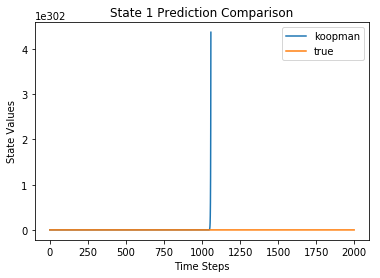

In [23]:
plt.plot(x_koop,label="koopman")
plt.plot(x_true[:,0],label="true")
plt.legend()
plt.xlabel("Time Steps")
plt.ylabel("State Values")
plt.title("State 1 Prediction Comparison")
plt.show()